## Battery SoC from Battery cycling Data

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import interp1d

df = pd.read_csv("Battery_Data.csv")

print(df.head())

   Voltage_measured  Current_measured  Temperature_measured  Current_load  \
0          4.246711          0.000252              6.212696        0.0002   
1          4.246764         -0.001411              6.234019        0.0002   
2          4.039277         -0.995093              6.250255        1.0000   
3          4.019506         -0.996731              6.302176        1.0000   
4          4.004763         -0.992845              6.361645        1.0000   

   Voltage_load    Time  
0         0.000   0.000  
1         4.262   9.360  
2         3.465  23.281  
3         3.451  36.406  
4         3.438  49.625  


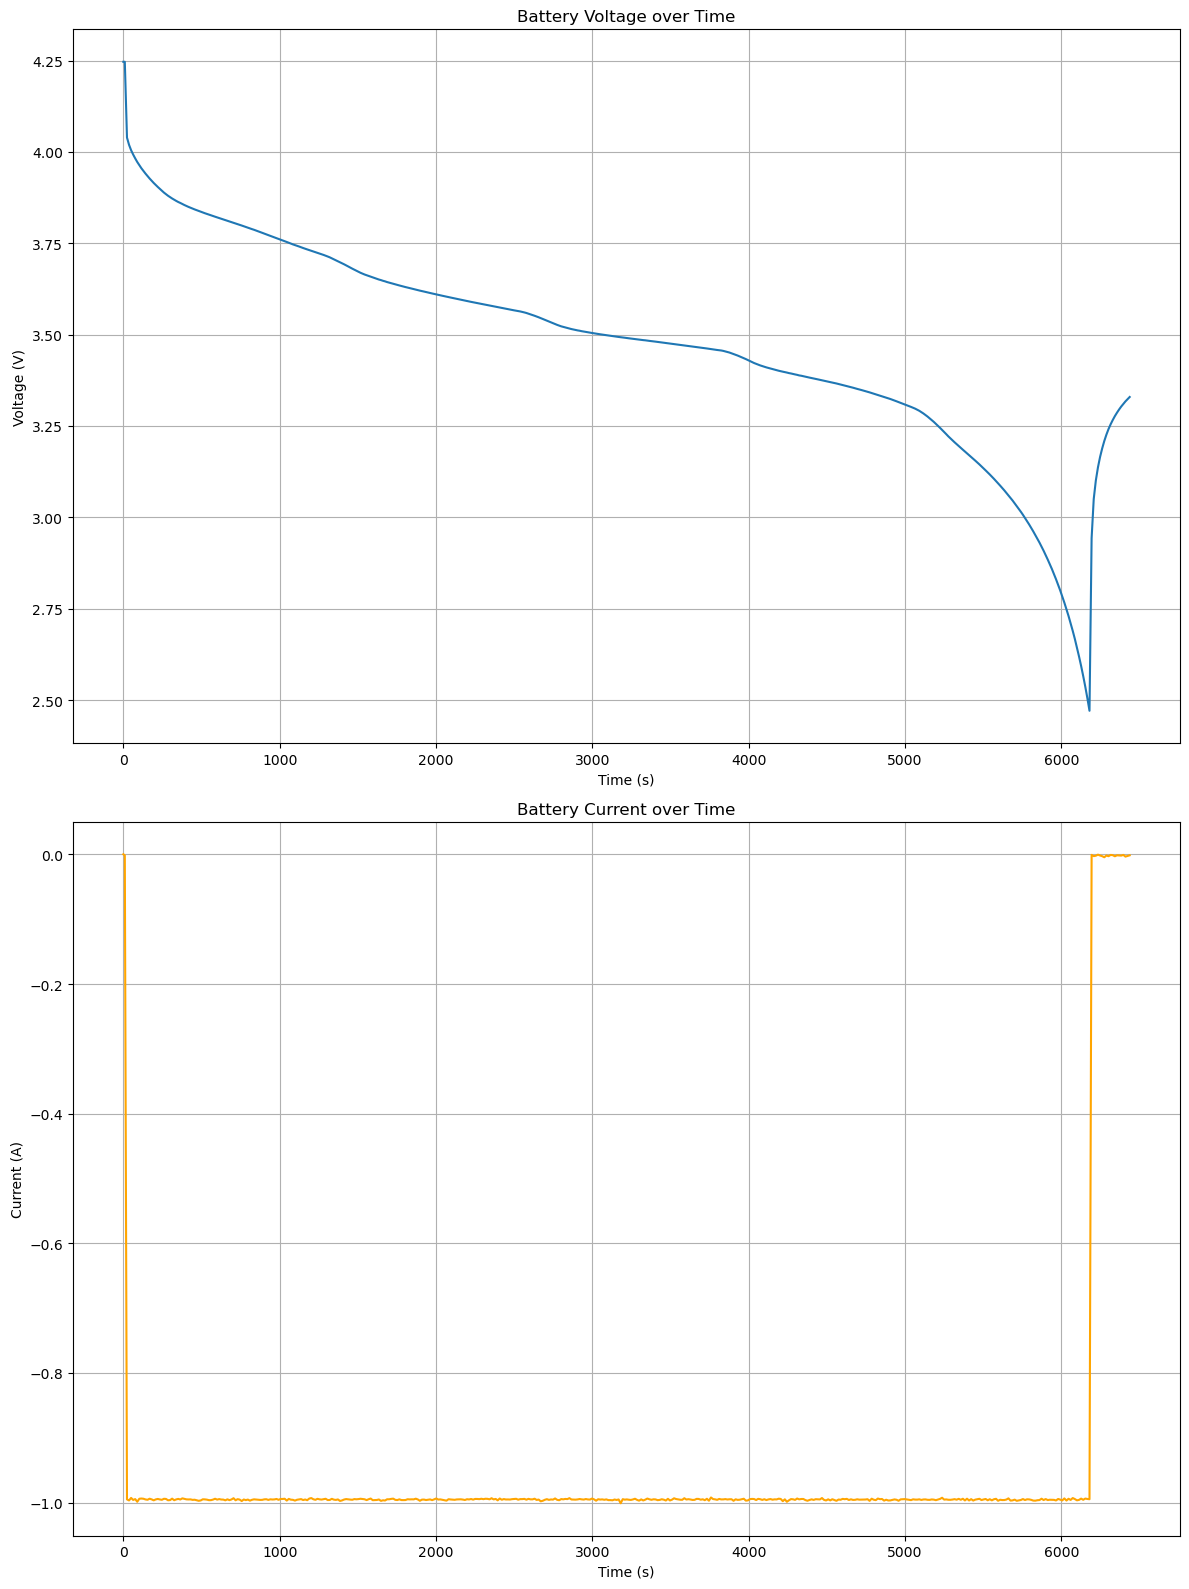

In [7]:
plt.figure(figsize = (12,16))
plt.subplot(2, 1, 1)
plt.plot(df['Time'], df['Voltage_measured'], label = 'Voltage (V)')
plt.xlabel('Time (s)')
plt.ylabel('Voltage (V)')
plt.title('Battery Voltage over Time')
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(df['Time'], df['Current_measured'], label='Current (A)', color='orange')
plt.xlabel('Time (s)')
plt.ylabel('Current (A)')
plt.title('Battery Current over Time')
plt.grid(True)

plt.tight_layout()
plt.show()

## Simple linear OCV Model
- Loading and inspecting real battery cycling data
- Calculating state of charge (SoC) from current integration (simple coulomb counting)
- Applying a simple equivalent circuit model to estimate terminal voltage
- Plotting SoC, voltage (measured and modeled), and current over time
- Detecting charge and discharge cycles automatically from current direction

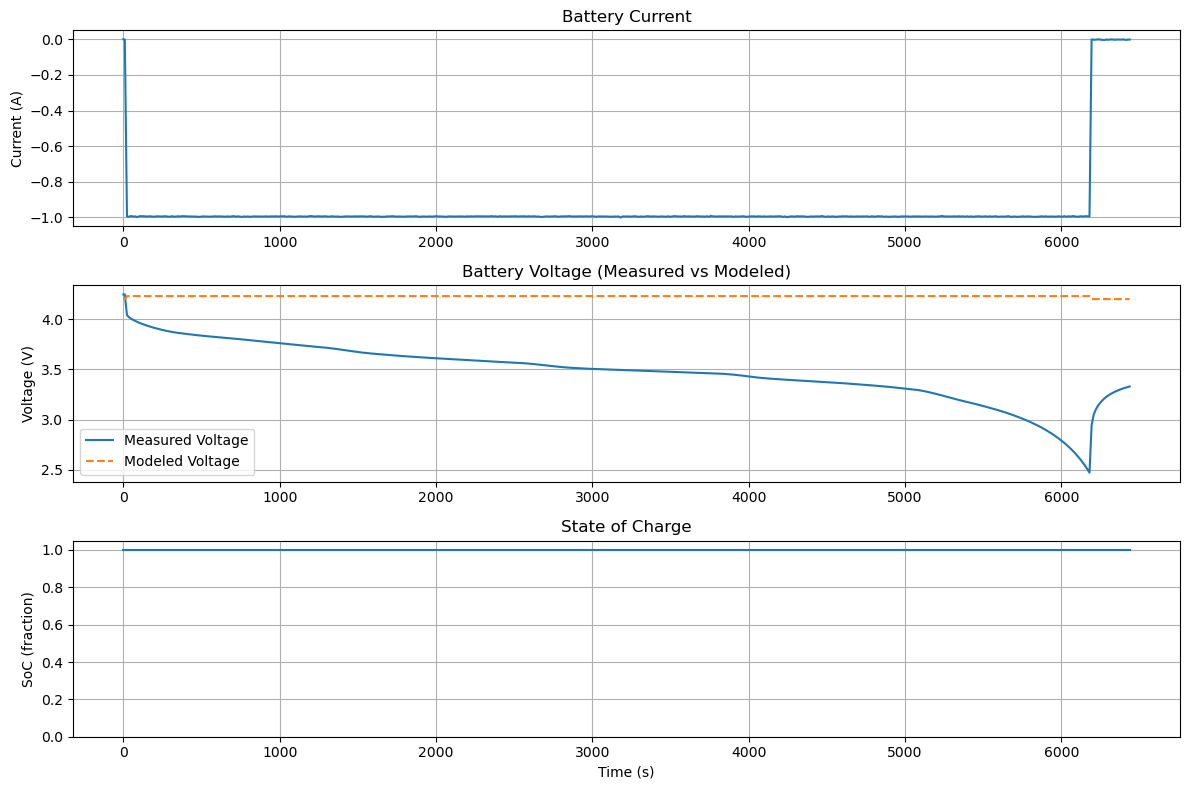

In [12]:
#taking import values from first code
time = df['Time']
voltage_meas = df['Voltage_measured']
current_meas = df['Current_measured']
# 
total_capacity_ah = 1.6743047446975208
total_capacity_as = total_capacity_ah * 3600

soc = [1.0]
for i in range(1,len(current_meas)):
    dt = time[i] - time[i-1]
    delta_q = current_meas[i-1] * dt
    soc_new = soc[-1] - delta_q / total_capacity_as
    soc_new = np.clip(soc_new, 0, 1)
    soc.append(soc_new)
soc = np.array(soc)

# Realistic OCV vs SoC data points (typical curve for Li-ion)
soc_points = np.array([0.0, 0.1, 0.2, 0.3,0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
ocv_points = np.array([3.0, 3.4, 3.6, 3.7, 3.8, 3.9, 4.0, 4.05, 4.1, 4.15, 4.2])

ocv_curve = interp1d(soc_points, ocv_points, kind='linear', fill_value='extrapolate')

# Simple SoC-dependent resistance (Ohm)
def resistance_soc(soc_val):
    return 0.03 + 0.07 * (1 - soc_val)  # lower resistance at high SoC, higher at low SoC

# Model terminal voltage using refined OCV and resistance
voltage_model = ocv_curve(soc) - current_meas * resistance_soc(soc)

# Plot results
plt.figure(figsize=(12, 8))

plt.subplot(3, 1, 1)
plt.plot(time, current_meas, label='Current (A)')
plt.ylabel('Current (A)')
plt.title('Battery Current')
plt.grid()

plt.subplot(3, 1, 2)
plt.plot(time, voltage_meas, label='Measured Voltage')
plt.plot(time, voltage_model, '--', label='Modeled Voltage')
plt.ylabel('Voltage (V)')
plt.title('Battery Voltage (Measured vs Modeled)')
plt.legend()
plt.grid()

plt.subplot(3, 1, 3)
plt.plot(time, soc, label='SoC (Coulomb Counting)')
plt.ylabel('SoC (fraction)')
plt.xlabel('Time (s)')
plt.title('State of Charge')
plt.ylim([0, 1.05])
plt.grid()

plt.tight_layout()
plt.show()